# Feature Selection

**Feature selection** is the process of selecting a subset of relevant features from a larger set to improve model performance or reduce computational complexity. *Types of feature selection* refers to various methodologies or approaches used to select a subset of features from the original feature set. These methodologies can be broadly categorized into three main types:

* Filter Methods
* Wrapper Methods
* Embedded Methods

# Numerical Feature Selection

* **Filter Methods**


  1. **Mutual Information**: Measures the relationship between two random variables; assesses the information gain by measuring the relationship of features with the target variable.

  2. **Chi-Squared**: Measures the relationship between categorical independent variables and a categorical target variable; tests the association between two categorical variables.

  3. **f_classif**: is a feature selection method commonly employed to evaluate the influence of features on a classification task, often utilizing ANOVA (Analysis of Variance). ANOVA is utilized to determine the statistical significance of the relationship between each feature and the target variable. High F-statistic values resulting from ANOVA imply a substantial association between the feature and the target, indicating its importance for classification. Conversely, low F-statistic values suggest a weaker impact. This technique plays a crucial role in feature selection processes aimed at enhancing model performance by selecting the most informative features.

  4. **ROC_AUC**: Calculates the area under the Receiver Operating Characteristic (ROC) curve (AUC), evaluating classifier performance; a higher ROC AUC value indicates better classifier performance.

  5. **Correlation**: Measures the linear relationship between features; assesses the correlation between features using statistical metrics such as the Pearson correlation coefficient.

# Import Necessary Librares

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, mean_squared_error

# Import Dataset

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6000,0.6270,50,1
1,1,85,66,29,0,26.6000,0.3510,31,0
2,8,183,64,0,0,23.3000,0.6720,32,1
3,1,89,66,23,94,28.1000,0.1670,21,0
4,0,137,40,35,168,43.1000,2.2880,33,1


In [3]:
def load_dataset(dir, drop_labels, target):
  df = pd.read_csv(dir)
  X = df.drop(labels=drop_labels, axis=1)
  y = df[target]
  return X, y

In [4]:
dir = "/content/drive/MyDrive/Colab Notebooks/datasets/diabetes.csv"
X, y = load_dataset(dir, drop_labels=["Outcome"], target="Outcome")

In [5]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6000,0.6270,50
1,1,85,66,29,0,26.6000,0.3510,31
2,8,183,64,0,0,23.3000,0.6720,32
3,1,89,66,23,94,28.1000,0.1670,21
4,0,137,40,35,168,43.1000,2.2880,33


In [6]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [8]:
y.isnull().sum()

0

In [9]:
X.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

In [10]:
zero_columns = [col for col in X.columns if (X[col].min() == 0 and col not in ["Pregnancies"])]
for col in zero_columns:
  X[col] = np.where(X[col] == 0, np.nan, X[col])

In [11]:
X.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

In [12]:
def fill_na_with_median(dataframe):
  dataframe = dataframe.apply(lambda x: x.fillna(x.median()) if x.dtype not in ["category", "object", "bool"] else x, axis=0)
  return dataframe

In [13]:
X = fill_na_with_median(X)

In [14]:
X.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

# Split Dataset

In [20]:
def create_train_test(X, y, test_size=0.33):
  X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size, random_state=1)
  return X_train, X_test, y_train, y_test

In [21]:
X_train, X_test, y_train, y_test = create_train_test(X, y)

# Filter Based Feature Selection: Anova

In [22]:
def filter_based_feature_selection(X_train, y_train, X_test, score_func):
  model = SelectKBest(score_func=score_func, k='all')
  model.fit(X_train, y_train)
  X_train_model = model.transform(X_train)
  X_test_model = model.transform(X_test)
  return X_train_model, X_test_model, model

In [23]:
X_train_model, X_test_model, model = filter_based_feature_selection(X_train, y_train, X_test, score_func=f_classif)

In [24]:
for i in range(len(model.scores_)):
  print(f"Feature: {i} Score: {model.scores_[i]}")


Feature: 0 Score: 16.527384507997283
Feature: 1 Score: 134.74359786862397
Feature: 2 Score: 10.491396711947141
Feature: 3 Score: 18.947687279611863
Feature: 4 Score: 28.832322500369134
Feature: 5 Score: 62.97168216414612
Feature: 6 Score: 13.37714228723036
Feature: 7 Score: 25.12643971427903


In [25]:
def plot_results(model, plot=True):
  output = pd.Series(model.scores_)
  output = output.sort_values(ascending=False)
  print("Features and Scores")
  for i, out in enumerate(output):
    print(f"Feature: {output.index[i]} Score: {out}")

  if plot:
    plt.bar([i for i in range(len(model.scores_))], model.scores_)
    plt.show()

Features and Scores
Feature: 1 Score: 134.74359786862397
Feature: 5 Score: 62.97168216414612
Feature: 4 Score: 28.832322500369134
Feature: 7 Score: 25.12643971427903
Feature: 3 Score: 18.947687279611863
Feature: 0 Score: 16.527384507997283
Feature: 6 Score: 13.37714228723036
Feature: 2 Score: 10.491396711947141


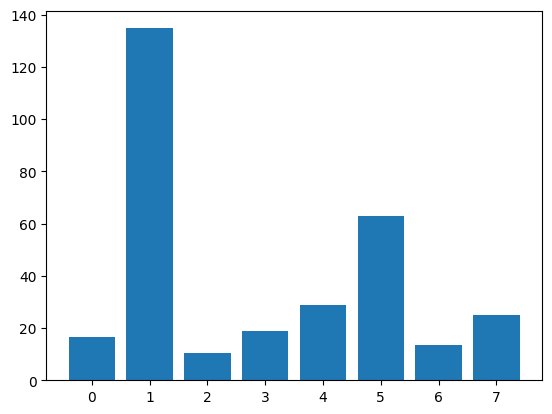

In [26]:
plot_results(model)

In [27]:
def filter_based_FS(X, y, score_func, test_size=0.33, plot=True):

  # Split Dataset
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

  # Filter Based Methods
  model = SelectKBest(score_func=score_func, k='all')
  model.fit(X_train, y_train)
  X_train_model = model.transform(X_train)
  X_test_model = model.transform(X_test)

  # Plot Results
  output = pd.Series(model.scores_)
  output.index = X_train.columns
  output = output.sort_values(ascending=False)
  print("Features and Scores")
  for i, out in enumerate(output):
    print(f"Feature: {output.index[i]} Score: {out}")

  if plot:
    plt.bar(output.index, model.scores_)
    plt.xticks(rotation='vertical')
    plt.title(f"Feature Importance for Score Function: {score_func.__name__}")
    plt.xlabel("Feature Index")
    plt.ylabel("Score")
    plt.show()

Features and Scores
Feature: Glucose Score: 134.74359786862397
Feature: BMI Score: 62.97168216414612
Feature: Insulin Score: 28.832322500369134
Feature: Age Score: 25.12643971427903
Feature: SkinThickness Score: 18.947687279611863
Feature: Pregnancies Score: 16.527384507997283
Feature: DiabetesPedigreeFunction Score: 13.37714228723036
Feature: BloodPressure Score: 10.491396711947141


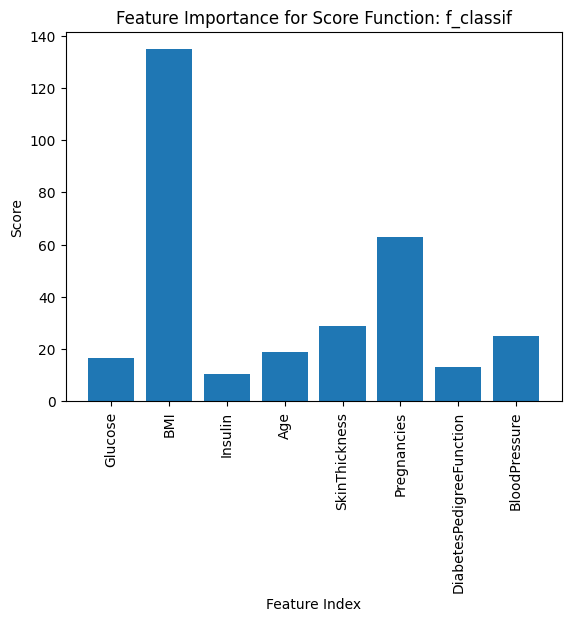

In [28]:
filter_based_FS(X, y, score_func=f_classif)

# Filter Based Feature Selection: Anova + Chi2

In [29]:
def filter_based_FS(X, y, score_funcs, test_size=0.33, plot=True):

    # Split Dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

    for score_func in score_funcs:
        # Filter Based Methods
        model = SelectKBest(score_func=score_func, k='all')
        model.fit(X_train, y_train)
        X_train_model = model.transform(X_train)
        X_test_model = model.transform(X_test)

        # Plot Results
        output = pd.Series(model.scores_)
        output.index = X_train.columns
        output = output.sort_values(ascending=False)
        print(f"Features and Scores for Score Function: {score_func.__name__}")
        for i, out in enumerate(output):
            print(f"Feature: {output.index[i]} Score: {out}")

        if plot:
            plt.figure(figsize=(8, 6))
            plt.xticks(rotation='vertical')
            plt.bar(output.index, model.scores_)
            plt.title(f"Feature Importance for Score Function: {score_func.__name__}")
            plt.xlabel("Feature Index")
            plt.ylabel("Score")
            plt.show()

Features and Scores for Score Function: f_classif
Feature: Glucose Score: 134.74359786862397
Feature: BMI Score: 62.97168216414612
Feature: Insulin Score: 28.832322500369134
Feature: Age Score: 25.12643971427903
Feature: SkinThickness Score: 18.947687279611863
Feature: Pregnancies Score: 16.527384507997283
Feature: DiabetesPedigreeFunction Score: 13.37714228723036
Feature: BloodPressure Score: 10.491396711947141


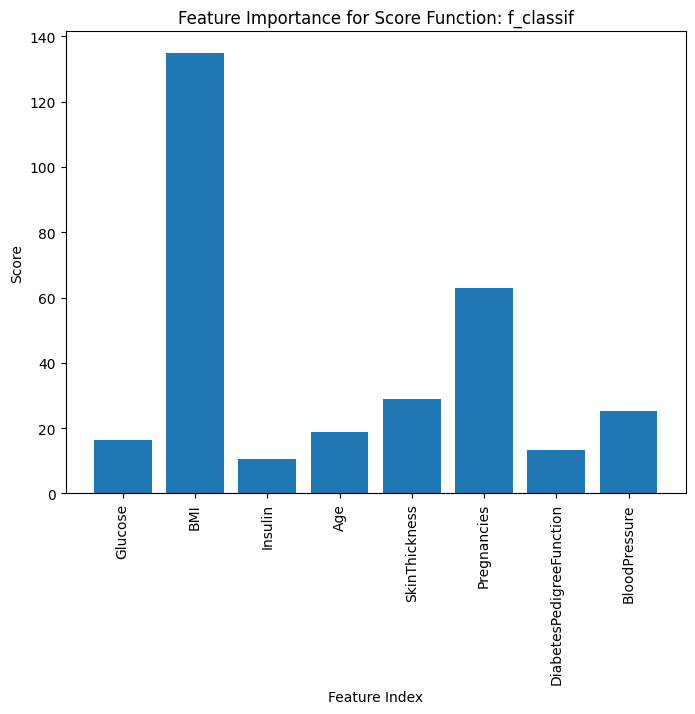

Features and Scores for Score Function: chi2
Feature: Insulin Score: 1298.345701541465
Feature: Glucose Score: 796.8783257889012
Feature: Age Score: 104.4052129225523
Feature: BMI Score: 84.05393926773033
Feature: SkinThickness Score: 48.74634550625772
Feature: Pregnancies Score: 47.63612386967638
Feature: BloodPressure Score: 23.519474095243357
Feature: DiabetesPedigreeFunction Score: 3.0894038172177227


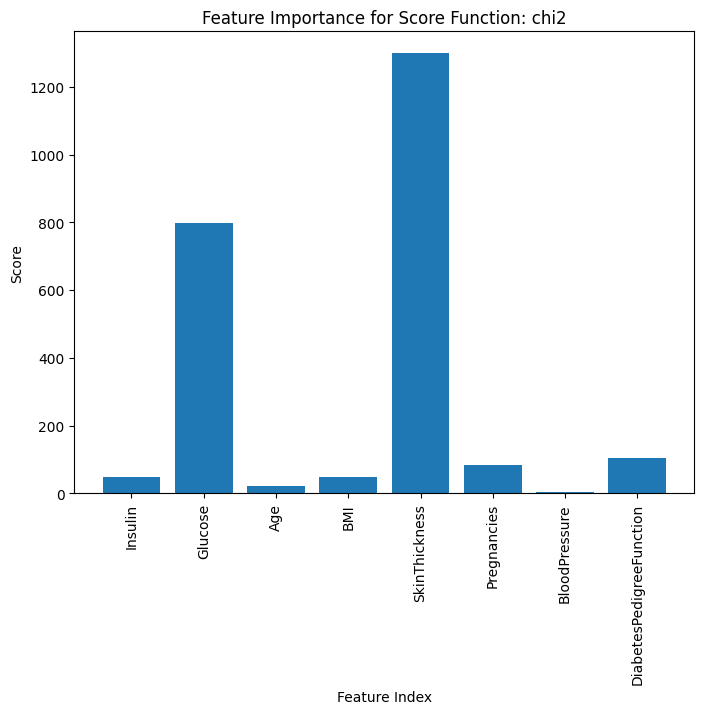

In [30]:
filter_based_FS(X, y, score_funcs=[f_classif, chi2])

In [31]:
def filter_based_FS(X, y, score_funcs, test_size=0.33, plot=True):

    # Split Dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

    plt.figure(figsize=(15, 5))
    for idx, score_func in enumerate(score_funcs, start=1):
        # Filter Based Methods
        model = SelectKBest(score_func=score_func, k='all')
        model.fit(X_train, y_train)
        X_train_model = model.transform(X_train)
        X_test_model = model.transform(X_test)

        # Plot Results
        output = pd.Series(model.scores_)
        output.index = X_train.columns
        output = output.sort_values(ascending=False)

        print(f"Features and Scores for Score Function: {score_func.__name__}")
        feature_scores = {"Feature": [], "Score": []}
        for i, out in enumerate(output):
            print(f"Feature: {output.index[i]} Score: {out}")
            feature_scores["Feature"].append(output.index[i])
            feature_scores["Score"].append(out)
        print(100*"#")

        # Plot subplot
        plt.subplot(1, len(score_funcs), idx)
        plt.xticks(rotation='vertical')
        plt.bar(output.index, model.scores_)
        plt.title(f"Feature Importance for Score Function: {score_func.__name__}")
        plt.xlabel("Feature Index")
        plt.ylabel("Score")

    plt.tight_layout()
    plt.show()


# Filter Based Feature Selection: Anova + Chi2 + Mutual_Information

Features and Scores for Score Function: f_classif
Feature: Glucose Score: 134.74359786862397
Feature: BMI Score: 62.97168216414612
Feature: Insulin Score: 28.832322500369134
Feature: Age Score: 25.12643971427903
Feature: SkinThickness Score: 18.947687279611863
Feature: Pregnancies Score: 16.527384507997283
Feature: DiabetesPedigreeFunction Score: 13.37714228723036
Feature: BloodPressure Score: 10.491396711947141
####################################################################################################
Features and Scores for Score Function: chi2
Feature: Insulin Score: 1298.345701541465
Feature: Glucose Score: 796.8783257889012
Feature: Age Score: 104.4052129225523
Feature: BMI Score: 84.05393926773033
Feature: SkinThickness Score: 48.74634550625772
Feature: Pregnancies Score: 47.63612386967638
Feature: BloodPressure Score: 23.519474095243357
Feature: DiabetesPedigreeFunction Score: 3.0894038172177227
###########################################################################

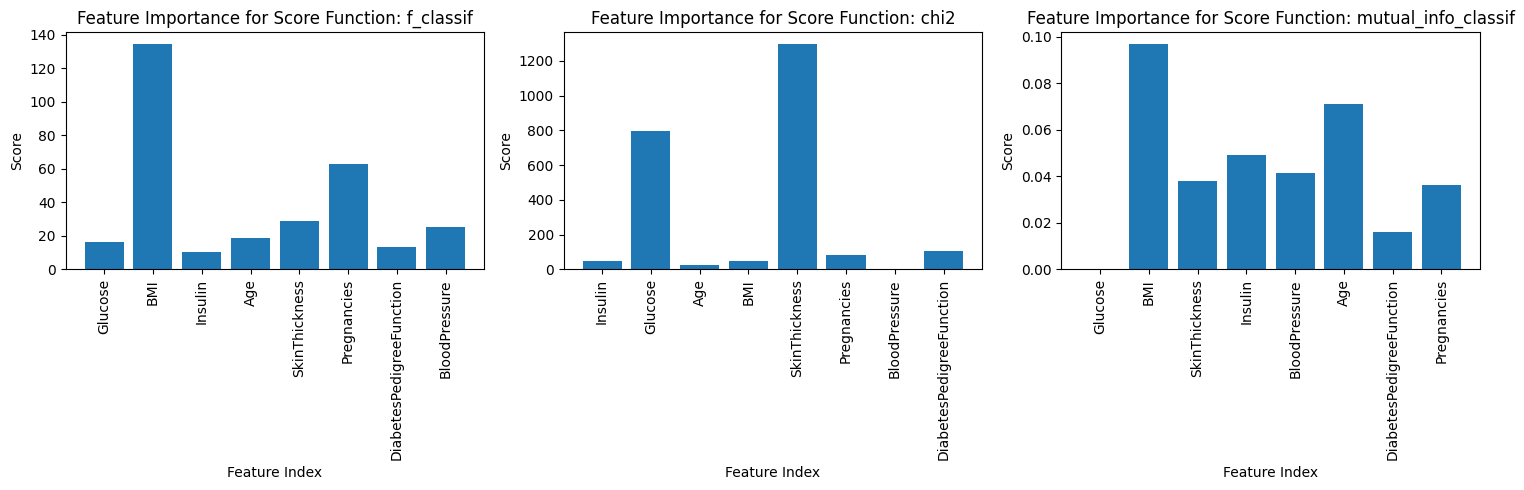

In [32]:
filter_based_FS(X, y, score_funcs=[f_classif, chi2, mutual_info_classif])

# ROC_AUC

ROC AUC (Receiver Operating Characteristic Area Under the Curve) is a metric used to measure the performance of a classification model. The ROC curve illustrates the relationship between sensitivity (true positive rate) and (1 - false positive rate). The area under the ROC curve (AUC) is a measure of the model's classification ability. ROC AUC ranges from 0 to 1, where a value closer to 1 indicates a model with excellent classification ability, while a value closer to 0.5 suggests that the model performs no better than random classification. Therefore, in feature selection methods, ROC AUC can be used to assess the contribution of each feature to the model's classification performance. The ROC AUC values of features can help evaluate how adding or removing different features affects the model's performance, with higher ROC AUC values suggesting that a particular feature may enhance the model's performance.

In [33]:
def feature_roc_auc_scores(X, y, roc_auc_value=0.6, test_size=0.33, plot=True ):
    # Split Dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

    # Calculate ROC AUC scores for each feature
    roc_values = []
    for feature in X_train.columns:
        clf = DecisionTreeClassifier()
        clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
        y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
        roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

    # Add variable names and order for clearer visualization
    roc_values = pd.Series(roc_values)
    roc_values.index = X_train.columns
    roc_values_sorted = roc_values.sort_values(ascending=False)

    # Plotting
    roc_values_sorted.plot.bar(figsize=(20, 8))
    plt.xlabel('Features')
    plt.ylabel('ROC AUC')
    plt.title('ROC AUC Scores for Each Feature')
    plt.axhline(roc_auc_value, color='red', linestyle='--', label='Random Guess')
    plt.legend()
    plt.show()

    # Count features with ROC AUC > roc_auc_value
    num_features_above_random = (roc_values_sorted > roc_auc_value).sum()
    print(f'Number of features with ROC AUC > {roc_auc_value}: {num_features_above_random}')

    print("Features with ROC AUC > {:.2f}:".format(roc_auc_value))
    for feature, roc in roc_values_sorted.items():
        if roc > roc_auc_value:
            print(f"{feature}: {roc}")

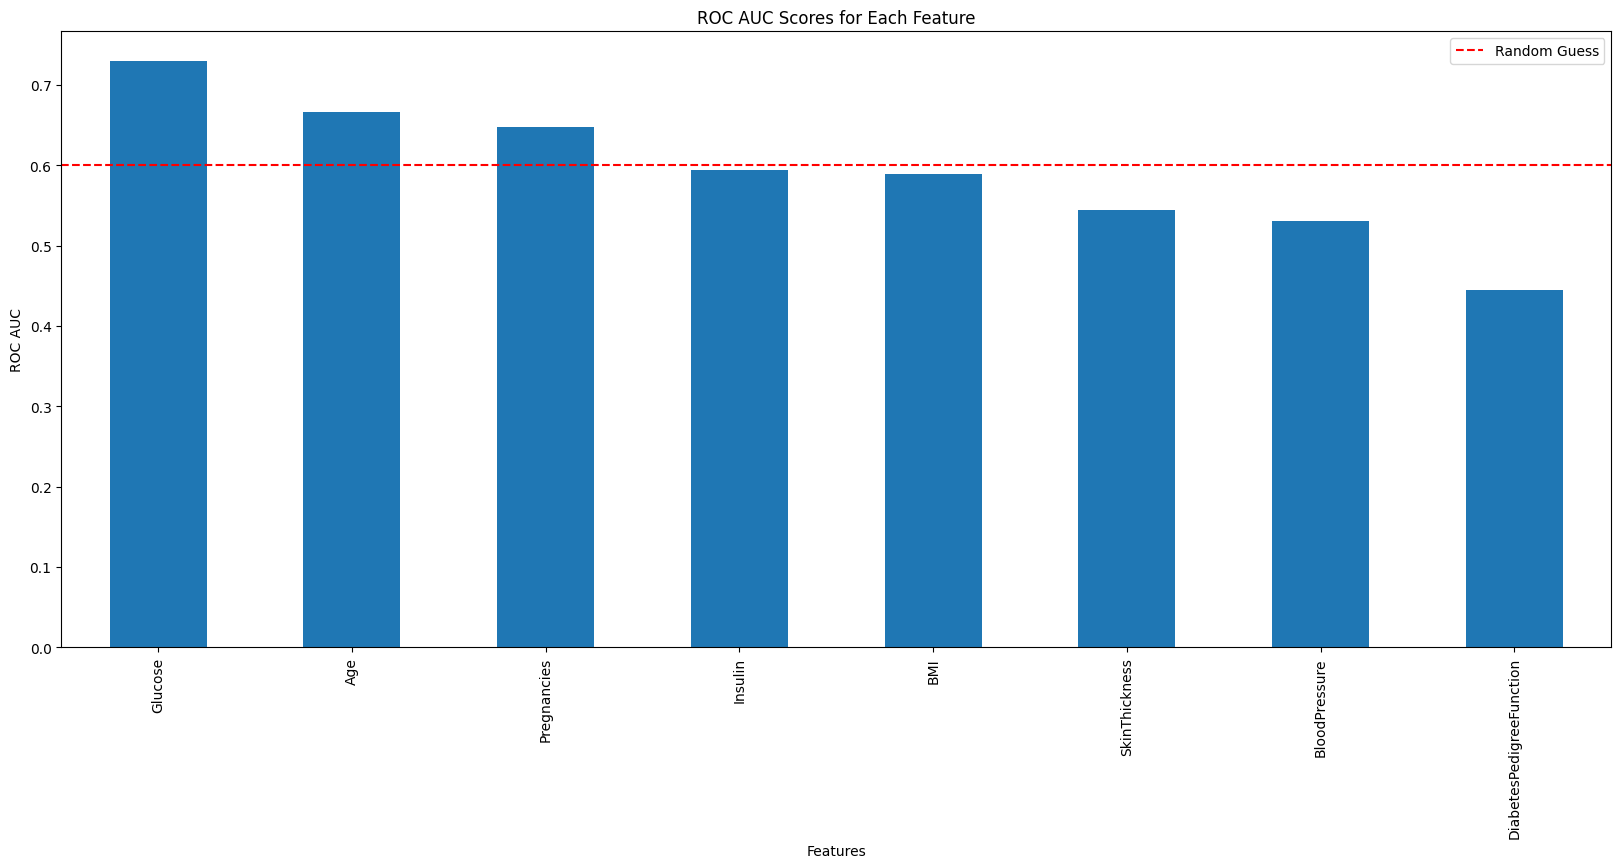

Number of features with ROC AUC > 0.6: 3
Features with ROC AUC > 0.60:
Glucose: 0.730072463768116
Age: 0.666935050993022
Pregnancies: 0.6474100912506708


In [34]:
feature_roc_auc_scores(X, y)

# Correlation

Measures the linear relationship between features; assesses the correlation between features using statistical metrics such as the Pearson correlation coefficient.

In [35]:
def feature_selection_correlation(X, y, test_size=0.33, threshold=0.8):

    # Split Dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

    # Build a Dataframe with Correlation between Features
    corr_matrix = X_train.corr()
    # Take absolute values of correlated coefficients
    corr_matrix = corr_matrix.abs().unstack()
    corr_matrix = corr_matrix.sort_values(ascending=False)
    # Take only features with correlation above threshold
    corr_matrix = corr_matrix[(corr_matrix >= threshold) & (corr_matrix < 1)]
    corr_matrix = pd.DataFrame(corr_matrix).reset_index()
    corr_matrix.columns = ['feature1', 'feature2', 'Correlation']

    # Get groups of features that are correlated amongs themselves
    grouped_features = []
    correlated_groups = []

    for feature in corr_matrix.feature1.unique():
        if feature not in grouped_features:
            # Find all features correlated to a single feature
            correlated_block = corr_matrix[corr_matrix.feature1 == feature]
            grouped_features = grouped_features + list(correlated_block.feature2.unique()) + [feature]

            # Append block of features to the list
            correlated_groups.append(correlated_block)

    if len(correlated_groups) == 0:
        print('No correlated feature groups found above the threshold of {}.'.format(threshold))
        return None, None

    print('Found {} correlated feature groups'.format(len(correlated_groups)))
    print('out of {} total features.'.format(X_train.shape[1]))

    # Visualize Correlated Feature Groups
    for group in correlated_groups:
        print(group)
        print('\n')

    # Random Forest Classifier for Feature Importance
    features = list(group.feature2.unique())
    rfc = RandomForestClassifier(n_estimators=20, random_state=101, max_depth=4)
    rfc.fit(X_train[features].fillna(0), y_train)

    # Get Feature Importance using RFC
    importance = pd.concat([pd.Series(features), pd.Series(rfc.feature_importances_)], axis=1)
    importance.columns = ['feature', 'importance']
    importance_sorted = importance.sort_values(by='importance', ascending=False)

    # Plot Feature Importance
    plt.figure(figsize=(10, 6))
    plt.bar(importance_sorted['feature'], importance_sorted['importance'], color='skyblue')
    plt.xlabel('Feature Name')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.xticks(rotation=90)
    plt.show()

    return correlated_groups, importance_sorted

In [36]:
correlated_groups, importance_sorted = feature_selection_correlation(X, y, threshold=0.9)

No correlated feature groups found above the threshold of 0.9.


In [37]:
def high_correlated_cols(X, corr_th=0.9, plot=True, remove_correlated_variables=False):
    num_cols = [col for col in X.columns if X[col].dtypes in ["uint8", "int64", "float64"]]
    corr = X[num_cols].corr()
    corr_matrix = corr.abs()
    upper_triangle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

    if drop_list == []:
        print("############## After Correlation Analysis, You Don't Need to Remove Variables ##############")

    if plot:
        sns.set(rc={'figure.figsize': (6, 3)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()

    if remove_correlated_variables:
      new_df = X.drop(drop_list, axis=1)
      sns.set(rc={'figure.figsize': (6,3)})
      sns.heatmap(new_df.corr(), cmap="RdBu", annot=True, fmt=".2f")
      plt.show()

    return drop_list, new_df

############## After Correlation Analysis, You Don't Need to Remove Variables ##############


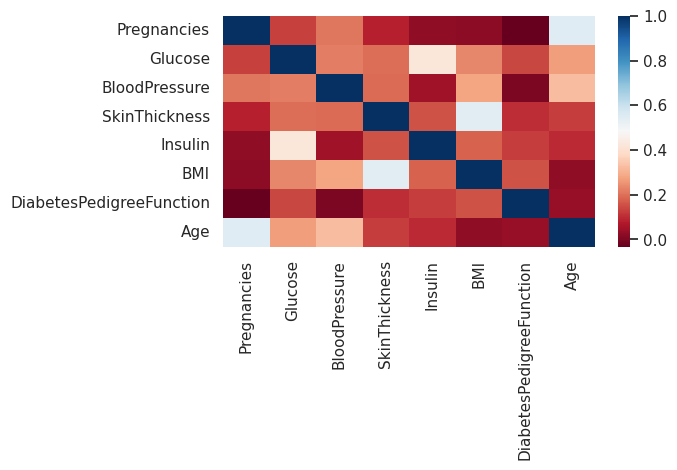

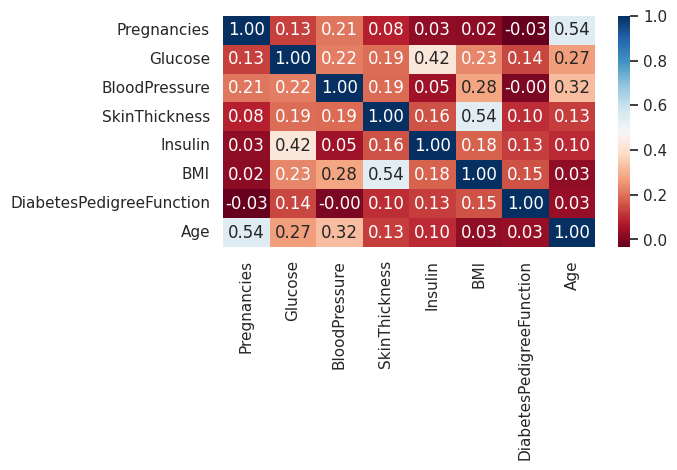

In [40]:
drop_list, new_df = high_correlated_cols(X, remove_correlated_variables=True)